# **ATLAS/ICESat-2 Land Ice Height Changes ATL11 Exploratory Data Analysis**

Adapted from https://github.com/suzanne64/ATL11/blob/master/intro_to_ATL11.ipynb

In [ ]:
import collections
import os
import glob

import pointCollection.is2_calendar

import dask
import dask.array
import datashader
import holoviews as hv
import holoviews.operation
import hvplot.dask
import hvplot.pandas
import hvplot.xarray

# import intake
import geopandas as gpd
import numpy as np
import pandas as pd
import pygmt
import pyproj
import shapely
import tqdm
import xarray as xr
import zarr

In [2]:
client = dask.distributed.Client(n_workers=64, threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:34953 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 201.22 GB


# Load Data from Zarr

Let's start by getting our data and running some preprocessing steps:
- Load 1385 (reference ground tracks) ATL11/*.zarr files
- Convert coordinates from longitude/latitude to x/y
- Convert GPS delta_time to UTC time
- Mask out low quality height (h_corr) data

In [3]:
stores = glob.glob(pathname="ATL11.001z123/ATL11_*.zarr")
print(f"{len(stores)} reference ground track Zarr stores")

1385 reference ground track Zarr stores


In [4]:
ds = xr.open_mfdataset(
    paths=stores,
    group="pt123",
    engine="zarr",
    combine="nested",
    concat_dim="ref_pt",
    parallel="True",
    backend_kwargs={"consolidated": True},
)
# ds = ds.unify_chunks().compute()
# TODO use intake
# source = intake.open_ndzarr(url="ATL11.001z123/ATL11_0*.zarr")

## Convert geographic lon/lat to x/y

To center our plot on the South Pole,
we'll reproject the original longitude/latitude coordinates
to the Antarctic Polar Stereographic (EPSG:3031) projection.

In [5]:
lonlat_to_xy = lambda longitude, latitude: pyproj.Proj(projparams=3031)(
    longitude, latitude
)

In [6]:
x, y = lonlat_to_xy(ds.longitude.values, ds.latitude.values)
ds["x"] = xr.DataArray(data=x, coords=ds.longitude.coords)
ds["y"] = xr.DataArray(data=y, coords=ds.latitude.coords)

In [7]:
# Also set x, y as coordinates in xarray.Dataset
ds = ds.set_coords(names=["x", "y"])
# ds = ds.set_index(x="x", y="y")

## Convert delta_time to utc_time

To get more human-readable datetimes,
we'll convert the delta_time attribute from the original GPS time format
(nanoseconds since the beginning of ICESat-2 starting epoch)
to Coordinated Universal Time (UTC).
The reference date for the ICESat-2 Epoch is 2018 January 1st according to
https://github.com/SmithB/pointCollection/blob/master/is2_calendar.py#L11-L15

TODO: Account for [leap seconds](https://en.wikipedia.org/wiki/Leap_second)
in the future.

In [8]:
ICESAT2_EPOCH = np.datetime64(pointCollection.is2_calendar.t_0())
# ICESAT2_EPOCH = np.datetime64(datetime.datetime(2018, 1, 1, 0, 0, 0))

In [9]:
utc_time = dask.array.asarray(ICESAT2_EPOCH) + ds.delta_time.data
ds["utc_time"] = xr.DataArray(data=utc_time, coords=ds.delta_time.coords)

## Mask out low quality height data

Good quality data has value 0, not so good is 1-8.
Look at the 'quality_summary_ref_surf' attribute in `ds`
for more information on what the quality flags mean.

We'll mask out values other than 0 with NaN using xarray's
[where](http://xarray.pydata.org/en/v0.15.1/indexing.html#masking-with-where).

In [10]:
ds["h_corr"] = ds.h_corr.where(cond=ds.quality_summary_ref_surf == 0)

# Pivot into a pandas/dask dataframe

To make data analysis and plotting easier,
let's flatten our n-dimensional `xarray.Dataset`
to a 2-dimensiontal `pandas.DataFrame` table format.

There are currently 6 cycles (as of March 2020),
and by selecting just one cycle at a time,
we can see what the height (`h_corr`)
of the ice is like at that time.

## Looking at ICESat-2 Cycle 6

In [ ]:
cycle_number: int = 6
# Subset to essential columns
essential_columns = [
    "x",
    "y",
    "utc_time",
    "h_corr",
    "longitude",
    "latitude",
    "delta_time",
    "cycle_number",
]
dss = ds.sel(cycle_number=cycle_number)[[*essential_columns]]
dss

In [12]:
points = hv.Points(
    data=dss,
    label=f"Cycle_{cycle_number}",
    kdims=["x", "y"],
    vdims=["utc_time", "h_corr", "cycle_number"],
    datatype=["xarray"],
)

In [13]:
df = points.dframe()  # convert to pandas.DataFrame, slow
df = df.dropna()  # drop empty rows
print(len(df))
df.head()

39721113


,x,y,utc_time,h_corr,cycle_number
98215,875866.803217,-2.191334e+06,2020-02-01 18:03:28.174083225,-52.742803,6
98216,875851.241069,-2.191275e+06,2020-02-01 18:03:28.178659812,-52.848337,6
98217,875836.625343,-2.191217e+06,2020-02-01 18:03:28.186106972,-52.702757,6
98218,875822.042305,-2.191158e+06,2020-02-01 18:03:28.195041671,-52.711233,6
98219,875807.459558,-2.191099e+06,2020-02-01 18:03:28.204009302,-52.781705,6


### Plot a sample of the points over Antarctica

Let's take a look at an interactive map
of the ICESat-2 ATL11 height for Cycle 6!
We'll plot a random sample (n=5 million)
of the points instead of the whole dataset,
it should give a good enough picture.

In [ ]:
df.sample(n=5_000_000).hvplot.points(
    title=f"Elevation (metres) at Cycle {cycle_number}",
    x="x",
    y="y",
    c="h_corr",
    cmap="Blues",
    rasterize=True,
    hover=True,
)

## Subset to geographic region of interest (optional)

Take a geographical subset and save to a NetCDF/Zarr format for distribution.

In [15]:
# Kamb Ice Stream bounding box in EPSG:3031 coordinates
xmin, xmax, ymin, ymax = (
    -739741.7702261859,
    -411054.19240523444,
    -699564.516934089,
    -365489.6822096751,
)
cond = xr.ufuncs.logical_and(
    xr.ufuncs.logical_and(ds.x > xmin, ds.x < xmax),
    xr.ufuncs.logical_and(ds.y > ymin, ds.y < ymax),
)

In [16]:
# Do the actual computation to find data points within region of interest
ds_subset = ds.where(cond=cond, drop=True)
ds_subset = ds_subset.unify_chunks()
ds_subset = ds_subset.compute()

In [17]:
# Save to NetCDF/Zarr formats for distribution
ds_subset.to_netcdf(
    path="atl11_subset.nc", engine="h5netcdf",
)
ds_subset.to_zarr(
    store="atl11_subset.zarr", mode="w", consolidated=True,
)

In [18]:
# Look at Cycle Number 6 only for plotting
points_subset = hv.Points(
    data=ds_subset.sel(cycle_number=6)[[*essential_columns]],
    label="Cycle_6",
    kdims=["x", "y"],
    vdims=["utc_time", "h_corr", "cycle_number"],
    datatype=["xarray"],
)
df_subset = points_subset.dframe()

In [ ]:
# Plot our subset of points on an interactive map
df_subset.hvplot.points(
    title=f"Elevation (metres) at Cycle {cycle_number}",
    x="x",
    y="y",
    c="h_corr",
    cmap="Blues",
    rasterize=True,
    hover=True,
)

# Calculate Elevation Change (dh) over ICESAT-2 cycles!!

Let's take a look at the change in elevation over one recent ICESat-2 cycle.
From our loaded dataset (ds), we'll select Cycles 6 and 5,
and subtract the height (h_corr) between them to get a height difference (dh).

In [11]:
def calculate_delta_height(
    dataset: xr.Dataset, oldcyclenum: int = 5, newcyclenum: int = 6
) -> xr.DataArray:
    """
    Calculates ATL11 change in height between two cycles (new minus old).
    """

    oldcycle: xr.Dataset = dataset.sel(cycle_number=oldcyclenum)
    newcycle: xr.Dataset = dataset.sel(cycle_number=newcyclenum)

    delta_height: xr.DataArray = newcycle.h_corr - oldcycle.h_corr
    # delta_time: xr.DataArray = newcycle.delta_time - oldcycle.delta_time

    return delta_height

In [12]:
dh: xr.DataArray = calculate_delta_height(dataset=ds, oldcyclenum=5, newcyclenum=6)

In [13]:
# Persist data in memory
dh = dh.persist()

In [ ]:
delta_h = dh.dropna(dim="ref_pt").to_dataset(name="delta_height")
delta_h

In [ ]:
dhdf = delta_h.to_dataframe()
dhdf.head()

In [16]:
# dhdf.to_parquet("temp_dhdf.parquet")
# dhdf = pd.read_parquet("temp_dhdf.parquet")
# dhdf = dhdf.sample(n=1_000_000)

## Plot elevation difference for a region

Using [datashader](https://datashader.org) to make the plotting real fast,
it actually rasterizes the vector points into a raster grid,
since our eyes can't see millions of points that well anyway.
You can choose any region, but we'll focus on the Siple Coast Ice Streams.
Using [PyGMT](https://pygmt.org), we'll plot the Antarctic grounding line
as well as the ATL11 height changes overlaid with Subglacial Lake outlines
from [Smith et al., 2009](https://doi.org/10.3189/002214309789470879).

In [17]:
# Bounding Box in EPSG:3031 as minx, maxx, miny, maxy
BBox = collections.namedtuple(
    typename="BBox", field_names=["xmin", "xmax", "ymin", "ymax"]
)
region = BBox(-2700000, 2800000, -2200000, 2300000)  # Antarctica
region = BBox(-1000000, 250000, -1000000, -100000)  # Siple Coast
region = BBox(-500000, -400000, -600000, -500000)  # Kamb Ice Stream
region = BBox(-350000, -100000, -700000, -450000)  # Whillans Ice Stream

In [ ]:
# Datashade our height values (vector points) onto a grid (raster image)
canvas = datashader.Canvas(
    plot_width=450,
    plot_height=450,
    x_range=(region.xmin, region.xmax),
    y_range=(region.ymin, region.ymax),
)
agg_grid = canvas.points(
    source=dhdf, x="x", y="y", agg=datashader.mean(column="delta_height")
)
agg_grid

In [19]:
# Find subglacial lakes (Smith et al., 2009) within region of interest
subglacial_lakes_gdf = gpd.read_file(
    filename=r"Quantarctica3/Glaciology/Subglacial Lakes/SubglacialLakes_Smith.shp"
)
subglacial_lakes_gdf = subglacial_lakes_gdf.loc[
    subglacial_lakes_gdf.within(
        shapely.geometry.Polygon.from_bounds(
            xmin=region.xmin, xmax=region.xmax, ymin=region.ymin, ymax=region.ymax
        )
    )
]
subglacial_lakes_geom = [g for g in subglacial_lakes_gdf.geometry]
subglacial_lakes = [
    np.dstack(g.exterior.coords.xy).squeeze().astype(np.float32)
    for g in subglacial_lakes_geom
]

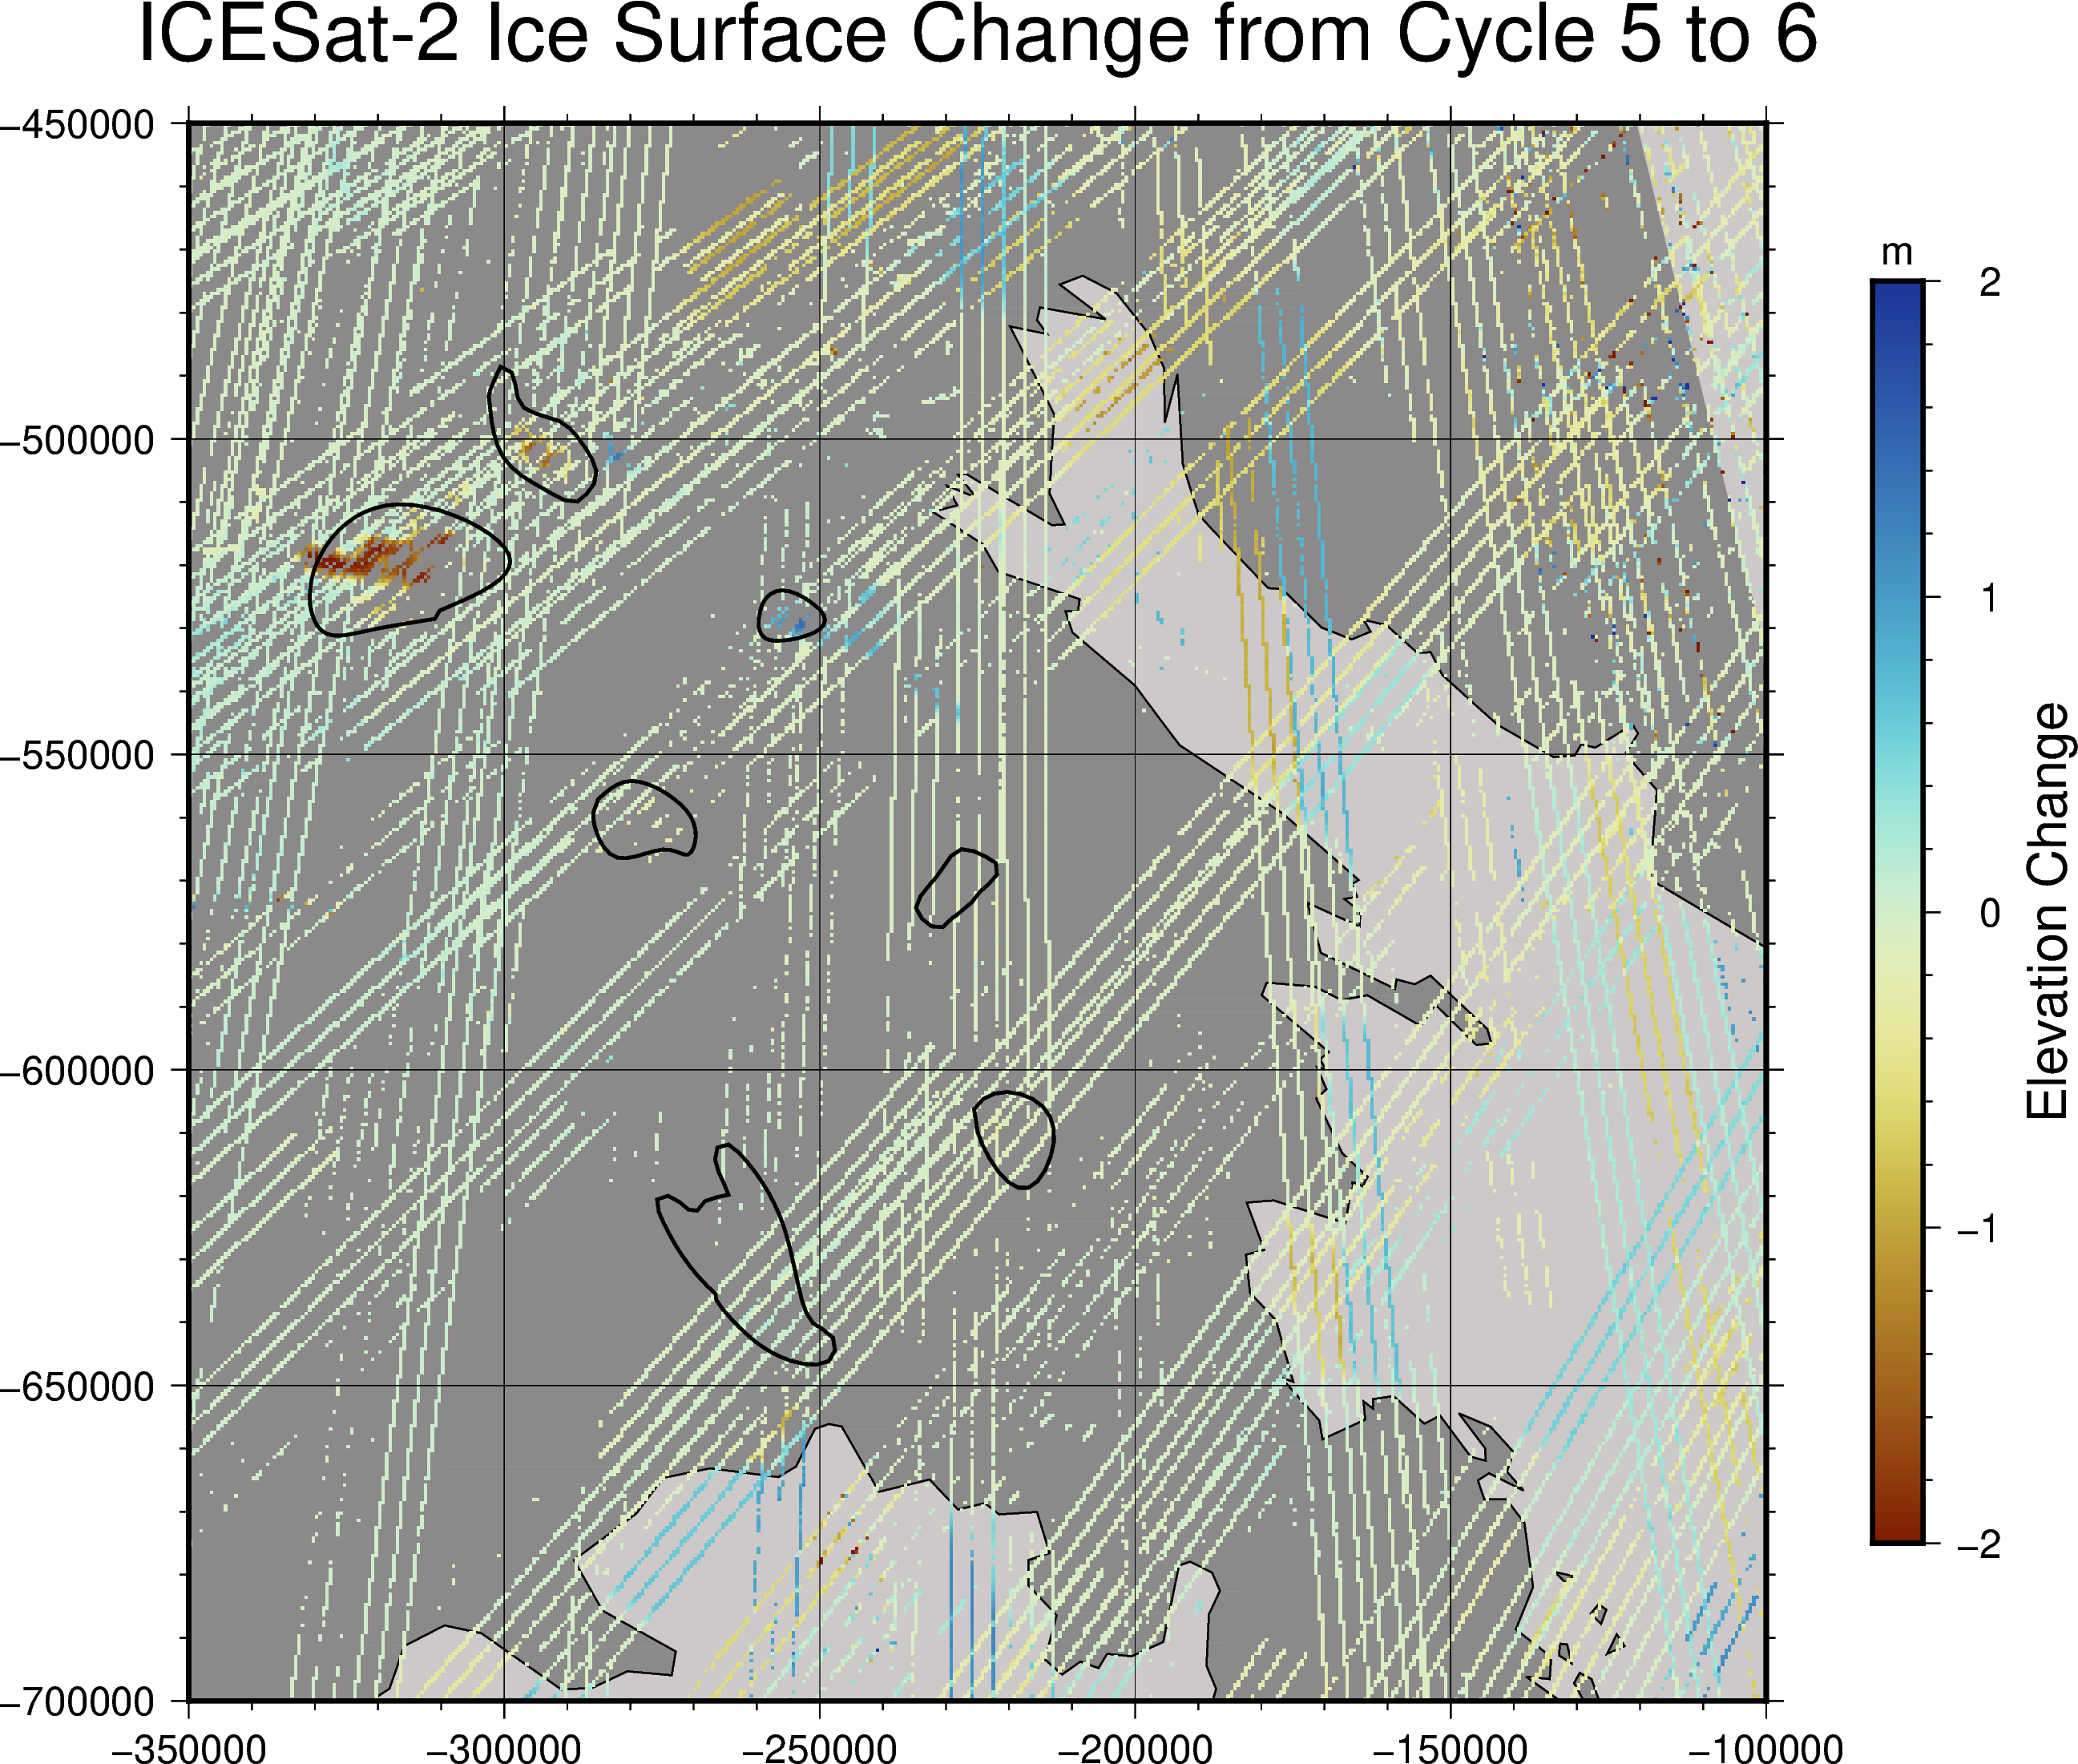

In [20]:
# Plot our map!
scale = "1:1500000"
fig = pygmt.Figure()
fig.coast(
    region=region,
    projection=f"s0/-90/-71/{scale}",
    area_thresh="+ag",
    resolution="i",
    shorelines="0.5p",
    land="snow4",
    water="snow3",
    V="q",
)
# fig.grdimage(
#    grid="Quantarctica3/SatelliteImagery/MODIS/MODIS_Mosaic.tif",
#    region=region,
#    projection=f"x{scale}",
#    I="+d",
# )
pygmt.makecpt(cmap="roma", series=[-2, 2])
fig.grdimage(
    grid=agg_grid,
    region=region,
    projection=f"x{scale}",
    frame=["afg", 'WSne+t"ICESat-2 Ice Surface Change from Cycle 5 to 6"'],
    Q=True,
)
for subglacial_lake in subglacial_lakes:
    fig.plot(data=subglacial_lake, L=True, pen="thick")
fig.colorbar(
    position="JCR", frame=["af", 'x+l"Elevation Change"', "y+lm"],
)
fig.show(width=600)

#### Non-PyGMT plotting code on PyViz stack

Meant to be a bit more interactive but slightly buggy,
need to sort out python dependency issues.

In [ ]:
import matplotlib.cm

In [ ]:
shade_grid = datashader.transfer_functions.shade(
    agg=agg_grid, cmap=matplotlib.cm.RdYlBu, how="linear", span=[-2, 2]
)
spread_grid = datashader.transfer_functions.dynspread(shade_grid)
spread_grid

In [ ]:
dhdf.hvplot.points(
    # title="Elevation Change (metres) from Cycle 5 to 6",
    x="x",
    y="y",
    c="delta_height",
    # cmap="RdYlBu",
    # aggregator=datashader.mean("delta_height"),
    rasterize=True,
    # responsive=True,
    # datashade=True,
    # dynamic=True,
    # dynspread=True,
    hover=True,
    height=400,
    symmetric=True,
    clim=(-20, 20),
)

In [ ]:
points = hv.Points(
    data=dhdf,
    kdims=["x", "y"],
    vdims=["delta_height"],
    # datatype=["xarray"],
)

In [ ]:
hv.operation.datashader.datashade(points)

In [ ]:
sorted(os.listdir("ATL11.001/"))
thefile = "ATL11.001/ATL11_076211_0104_02_v001.h5"

with h5py.File(thefile, mode="r") as h5f:
    print(h5f.keys())
    print(h5f["pt1"].keys())

with xr.open_dataset(thefile, group="pt1/ref_surf", engine="h5netcdf") as rs:
    # read in the along-track coordinates
    x_atc = rs.x_atc.to_masked_array()
    # N slope
    n_slope = rs.n_slope.to_masked_array()
    e_slope = rs.e_slope.to_masked_array()
    bad = n_slope == 1.7976931348623157e308
    bad |= e_slope == 1.7976931348623157e308
    n_slope[bad] = np.NaN
    e_slope[bad] = np.NaN
    slope_mag = np.sqrt(n_slope ** 2 + e_slope ** 2)
    # get the reference-surface quality summary
    r_quality_summary = rs.quality_summary.to_masked_array()

with xr.open_dataset(thefile, group="pt1/corrected_h", engine="h5netcdf") as ch:
    # read in the along-track coordinates
    ref_pt = ch.ref_pt.to_masked_array()
    # read in the corrected_h
    h_corr = ch.h_corr.to_masked_array()
    # mask out invalid values
    bad = h_corr == 1.7976931348623157e308
    h_corr[bad] = np.NaN

    # error
    h_corr_sigma = ch.h_corr_sigma.to_masked_array()
    bad = h_corr_sigma == 1.7976931348623157e308
    h_corr_sigma[bad] = np.NaN
    # systematic error
    h_corr_sigma_s = ch.h_corr_sigma_systematic.to_masked_array()
    bad = h_corr_sigma == 1.7976931348623157e308
    h_corr_sigma_s[bad] = np.NaN
    # get the ATL06-based quality summary
    h_quality_summary = ch.quality_summary.to_masked_array()
    # read the cycle_number
    cycle_num = ch.cycle_number.to_masked_array()


if 1 == 1:
    plt.figure()
    plt.subplot(211)
    for cycle in range(0, h_corr.shape[1]):
        plt.plot(x_atc, h_corr[:, cycle], ".", label=f"cycle {cycle}")
    plt.legend()
    plt.xlabel("along-track distance")
    plt.ylabel("height, m")

    plt.subplot(212)
    plt.plot(x_atc, np.sum(np.isfinite(h_corr), axis=1), ".")
    plt.xlabel("along-track x")
    plt.ylabel("number of cycles present")

x_rep = np.tile(x_atc[:, np.newaxis], [1, len(cycle_num)])
q_rep = np.tile(r_quality_summary[:, np.newaxis], [1, len(cycle_num)])

if 2 == 2:
    plt.figure()
    plt.plot(x_atc, r_quality_summary, ".")
    plt.xlabel("x_atc")
    plt.ylabel("reference-surface quality summary")


if 3 == 3:
    fig = plt.figure(2)
    plt.clf()
    plt.plot(
        x_rep.ravel()[q_rep.ravel() != 6], h_corr.ravel()[q_rep.ravel() != 6], "k."
    )
    plt.title("points with surface quality not equal to 6")
    # plt.gca().set_xlim([6.75e6, 6.87e6])
    plt.tight_layout()
    plt.show()

if 4 == 4:
    comblist = list(itertools.combinations(cycle_num, 2))
    plt.figure(len(comblist) + 1, figsize=(4, 2 * len(comblist) + 1))
    plt.clf()
    ax = []
    good = np.flatnonzero(q_rep[:, 0] != 6)

    # cycle-to-cycle elevation differences
    for j, (col1, col2) in enumerate(comblist, start=1):
        ax += [plt.subplot(len(comblist) + 1, 1, j)]
        col1 -= 1
        col2 -= 1

        this_dh = h_corr[good, col2] - h_corr[good, col1]
        # cycle-to-cycle difference errors are the quadratic sums of the cycle errors
        this_dh_sigma = np.sqrt(
            h_corr_sigma[good, col2] ** 2 + h_corr_sigma[good, col1] ** 2
        )
        # Likewise for systematic errors:
        this_dh_sigma_s = np.sqrt(
            h_corr_sigma_s[good, col2] ** 2 + h_corr_sigma_s[good, col1] ** 2
        )
        plt.errorbar(
            x_rep[good, col2].ravel(),
            this_dh,
            yerr=np.sqrt(this_dh_sigma ** 2 + this_dh_sigma_s ** 2),
            fmt="r.",
        )
        plt.errorbar(x_rep[good, col2].ravel(), this_dh, yerr=this_dh_sigma, fmt="k.")
        ax[-1].set_ylabel(f"cycle {col2+1} \n minus \n cycle {col1+1}")
        ax[-1].set_ylim([-5, 5])

    # plot of the number of cycles available:
    ax += [plt.subplot(len(comblist) + 1, 1, j + 1)]
    plt.plot(x_atc, np.sum(np.isfinite(h_corr) & (q_rep != 6), axis=1), ".")
    ax[-1].set_ylabel("# of cycles available")
    ax[-1].set_ylim([0, 3.5])

In [ ]:
def read_field(dataset: xr.Dataset, field: str):
    data = dataset[field].to_masked_array()
    bad1 = data == 1.7976931348623157e308
    data[bad1] = np.NaN
    bad2 = data == -1.7976931348623157e308
    data[bad2] = np.NaN
    return data


def read_ATL11(filepath: str, pair: str = "pt2", epsg: int = 3031):
    with xr.open_mfdataset(
        paths=filepath, group=f"{pair}/corrected_h", engine="h5netcdf"
    ) as ch:
        longitude = read_field(dataset=ch, field="longitude")
        latitude = read_field(dataset=ch, field="latitude")
        h_corr = read_field(dataset=ch, field="h_corr")
        h_corr_sigma = read_field(dataset=ch, field="h_corr_sigma")
        h_corr_sigma_s = read_field(dataset=ch, field="h_corr_sigma_systematic")
    with xr.open_mfdataset(
        paths=filepath, group=f"{pair}/ref_surf", engine="h5netcdf"
    ) as rs:
        x_atc = read_field(dataset=rs, field="x_atc")
        quality = rs["quality_summary"].to_masked_array().data
    h_corr[quality == 6] = np.NaN
    x, y = pyproj.Proj(projparams=epsg)(longitude, latitude)
    return x_atc, x, y, h_corr, np.sqrt(h_corr_sigma ** 2 + h_corr_sigma_s ** 2)


x_atc = []
x = []
y = []
h_corr = []
sigma_h = []
for pair in ["pt1", "pt2", "pt3"]:
    xx_atc, xx, yy, hh, ss = read_ATL11(
        filepath="ATL11.001/ATL11_????11_0105_02_v001.h5", pair=pair
    )
    x_atc += [xx_atc]
    x += [xx]
    y += [yy]
    h_corr += [hh]
    sigma_h += [ss]

# with xr.open_mfdataset(
#     paths="ATL11.001/ATL11_????11_0105_02_v001.h5",
#     group=f"{pair}/corrected_h",
#     engine="h5netcdf",
#     lock=False,
#     # combine="nested",
#     # concat_dim=None,
#     # drop_variables="delta_time"
# ) as ch:
#     pass

x_atc = np.concatenate(x_atc)
x = np.concatenate(x)
y = np.concatenate(y)
h_corr = np.concatenate(h_corr, axis=0)
sigma_h = np.concatenate(sigma_h, axis=0)

print(h_corr.shape)

if 5 == 5:
    c2: int = 5
    c1: int = 4
    plt.figure(figsize=[10, 10])
    plt.scatter(
        x=x[::20],
        y=y[::20],
        s=2,
        c=h_corr[::20, c2 - 1] - h_corr[::20, c1 - 1],
        vmin=-2,
        vmax=2,
        cmap="Spectral",
    )
    plt.axis("equal")
    hb = plt.colorbar()
    hb.set_label(f"cycle {c2} minus cycle {c1} elevation change (dh) in metres")

# TODO https://github.com/ICESAT-2HackWeek/elevation-change/blob/master/elevation_change_with_ATL11.ipynb

sdf = pd.DataFrame(sigma_h, columns=[f"s{i + 1}" for i in range(5)])

df = pd.concat(
    objs=[
        pd.DataFrame(data=x_atc, columns=["x_atc"]),
        pd.DataFrame(data=x, columns=["x"]),
        pd.DataFrame(data=y, columns=["y"]),
        pd.DataFrame(data=h_corr, columns=[f"h{i + 1}" for i in range(5)]),
    ],
    axis="columns",
)
df.head()

# TODO range of dh along window view of point with big change

# Cycle 1 - Spring2018 - 13Oct2018 - 28Dec2018  -ve MassBalance
# Cycle 2 - Summer2019 - 28Dec2018 - 29Mar2019 --ve MassBalance
# Cycle 3 - Autumn2019 - 29Mar2019 - 28Jun2019  +ve MassBalance *
# Cycle 4 - Winter2019 - 09Jul2019 - 26Sep2019 ++ve MassBalance *
# Cycle 5 - Spring2019 - 26Sep2019 - 26Dec2019  -ve MassBalance *
# Cycle 6 - Summer2020 - 26Dec2019 - 26Mar2020 --ve MassBalance

hmin = df[[f"h{i+1}" for i in range(5)]].min(axis="columns")  # minimum elevation
hmax = df[[f"h{i+1}" for i in range(5)]].max(axis="columns")  # maximum elevation
df["hrange"] = hmax - hmin  # range of elevation across all cycles
df.hrange.replace(to_replace=0.0, value=np.NaN, inplace=True)
df.to_csv("xyhr.csv")
# df = pd.read_csv("xyhr.csv", index_col=0)
bigdh = df[df["hrange"] > 5.5]  # find points where elevation range is greater than 5.5m
bigdh
bigdh.index

# TODO point in polygon (grounding line) to filter out ice shelf dynamics

for i in bigdh.index[:]:
    # i = 4848718
    temp_df = df.loc[i - 10 : i + 10]
    median_change = temp_df.hrange.median()
    if median_change >= 5.5 and median_change < 50:
        temp_sdf = sdf.loc[i - 10 : i + 10]
        for j in range(5):
            plt.errorbar(
                x=temp_df.x_atc,
                y=temp_df[f"h{j+1}"],
                yerr=temp_sdf[f"s{j+1}"],
                fmt="k.",
            )
            plt.scatter(x=temp_df.x_atc, y=temp_df[f"h{j+1}"], label=f"h{j+1}")
        plt.title(
            label=f"xy:{temp_df.loc[i].x},{temp_df.loc[i].y}\nindex:{i}, median_change:{median_change}m"
        )

        plt.gca().set_xlim(temp_df.x_atc[i - 10], temp_df.x_atc[i + 10])
        # plt.gca().set_ylim(160, 200)
        plt.legend()
        plt.show()

# Subglacial lake Slessor2 uplift
# -410918.8386,1029347.4666
# -408131.9125,1031128.9651
# Subglacial Lake Slessor4 drain
# -338117.9641,1110603.6373

# Subglacial Lake Whillans4/Mercer2 drainage
# -307154.8016,-507734.7378

# Subglacial Lake Macayeal 3 drainage (manually found)
# -734532.7023, -855436.2967

# Subglacial Lake Byrd 2 uplift (manually found, ~2m)
# 557187.1725,-855601.0561
# 555843.4189,-985710.3337 # Upstream Byrd Glacier ? rifting ??

# -741220.3139, 937483.8670 # Ronne-Filchner Ice Shelf
# -973351.7558, 272566.6157 # Ronne-Filchner Ice Shelf
# -1008445.1929,274272.3455  # Ronne-Filchner Ice Shelf
# 37261.1917,-1180880.8635 Ross Sea tidal motion
# -579964.1805,574791.5220 # Support Force Glacier at grounding line
# -1174079.4108,212533.0448 # Rutford Ice Stream/Shelf tidal motion?